In [1]:
import sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

60/94/120 Ah, 60Ah -> 22kWh
optional engine -> REx

In [2]:
df = pd.read_csv('data/AS24_BMWi3.csv', index_col=0)

In [25]:
df.head()

,model,version,equipments,mileage,mmyy,power,use_type,n_owners,gear,fuel_type,price,kW,age
0,BMW i3,Garanzia batterie e motore 12 mesi,['Brokar - Professional Car Brokerage - Interm...,109954.0,2013-08-01,75 kW (102 CV),Usato,3.0,Automatico,Elettrica,12900,75,8.252052
60,BMW i3,top ful ful optional,NaN,150000.0,2013-11-01,75 kW (102 CV),Usato,NaN,None,Elettrica,20000,75,8.000164
22,BMW i3,cerchi 19 pelle navi grande tetto apribile,NaN,65300.0,2013-12-01,75 kW (102 CV),Usato,NaN,None,Elettrica,14900,75,7.918027
33,BMW i3,NaN,NaN,68000.0,2014-02-01,75 kW (102 CV),Usato,NaN,Automatico,Elettrica,16650,75,7.748277
28,BMW i3,NaN,NaN,50000.0,2014-04-01,75 kW (102 CV),Usato,2.0,None,Elettrica,16000,75,7.586740


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 0 to 245
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   model       246 non-null    object 
 1   version     236 non-null    object 
 2   equipments  17 non-null     object 
 3   mileage     202 non-null    float64
 4   mmyy        246 non-null    object 
 5   power       246 non-null    object 
 6   use_type    246 non-null    object 
 7   n_owners    95 non-null     float64
 8   gear        246 non-null    object 
 9   fuel_type   246 non-null    object 
 10  price       246 non-null    int64  
dtypes: float64(2), int64(1), object(8)
memory usage: 23.1+ KB


In [31]:
#all the cars having null mileage are new
df[df.mileage.isna()]['mmyy'].unique()
#set mileage = 0
df.loc[df.mileage.isna(),'mileage'] = 0

In [6]:
#power
df.power.value_counts()

75 kW (102 CV)     150
125 kW (170 CV)     77
135 kW (184 CV)     18
1 kW (1 CV)          1
Name: power, dtype: int64

One has 1kW, which must be wrong

In [33]:
df['kW'] = df['power'].apply(lambda x: int(x.split()[0]))
df[df.kW==1]

,model,version,equipments,mileage,mmyy,power,use_type,n_owners,gear,fuel_type,price,kW,age
192,BMW i3,(I01) 120 Ah,NaN,119.0,2019-08-01,1 kW (1 CV),KM0,NaN,Automatico,Elettrica,35900,1,2.253297


In [34]:
#no info found. let's assume it has the more frequent power (75 kW)
df.loc[192, 'kW'] = 75

In [35]:
#fuel type columns
df.fuel_type.value_counts()

Elettrica            225
Elettrica/Benzina     21
Name: fuel_type, dtype: int64

In [38]:
# 'Elettrica/Benzina' means it has an extender range engine. But actually all of these cars have it.
#boole = df.fuel_type == 'Elettrica/Benzina'
#df[boole]

In [39]:
df.use_type.unique()

array(['Usato', 'Dimostrativo', 'KM0', 'Aziendale', 'Nuovo'], dtype=object)

In [40]:
#all these cars have automatic gear
df.gear.unique()

array(['Automatico', None, 'Manuale'], dtype=object)

In [42]:
df['mmyy'] = df['mmyy'].apply(pd.to_datetime)
df = df.sort_values(by=['mmyy'], ascending=True)

In [43]:
now = pd.to_datetime('11/2021')

In [44]:
df['age']  = (now - df.mmyy) / np.timedelta64(1, 'Y')

<IPython.core.display.Javascript object>


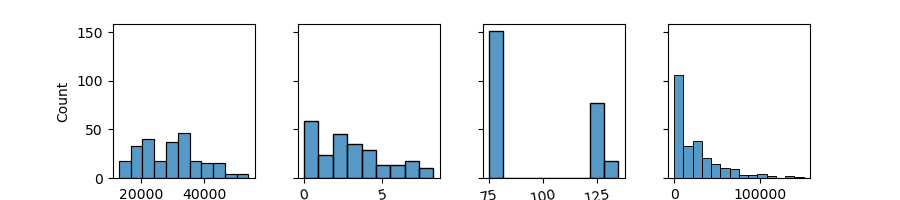

In [50]:
f, ax = plt.subplots(figsize=(9, 2), nrows=1, ncols=4, sharey=True, gridspec_kw={'hspace':0.4, 'wspace':0.3})
for i,var in enumerate(['price', 'age', 'kW','mileage']):
    g = sns.histplot(x=var, data=df, ax=ax[i])
    if i in [1,2]:
        ax[i].tick_params(axis='x', rotation=10)

<IPython.core.display.Javascript object>


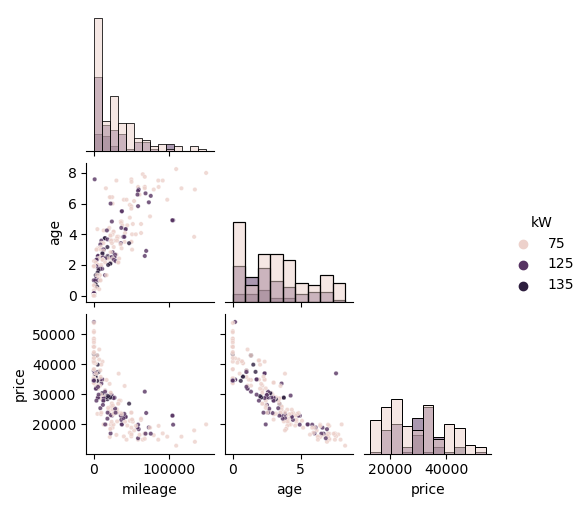

In [52]:
feat = ['mileage','kW','age','price']
g = sns.pairplot(df[feat], hue="kW", height=1.7, diag_kind="hist", corner=True, plot_kws={"s": 10, 'alpha':0.8})

In [71]:
#there are few outliers
bool_to_drop1 = (df.mileage > 65000) & (df.kW > 100) & (df.price>19500)
bool_to_drop2 = (df.price > 30000) & (df.age > 6.8)
idx_to_drop = df.index[(bool_to_drop1 | bool_to_drop2)]
df.drop(index=idx_to_drop, inplace=True)

In [92]:
mileage_sorted = df.mileage.sort_values(ascending=False)

<IPython.core.display.Javascript object>


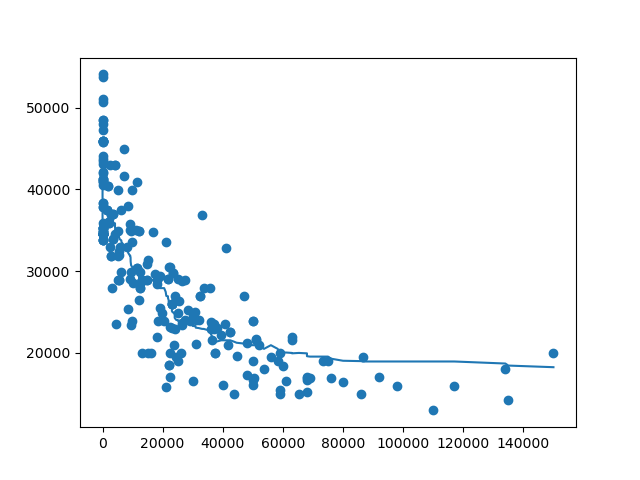

In [100]:
fig, ax = plt.subplots()
mean_price = df_mileage_sorted['price'].rolling(window=100, min_periods=20, center=True).median()
plt.scatter(df.mileage, df.price)
plt.plot(df_mileage_sorted.mileage, mean_price)


In [101]:
fig_of_merit = df.age + (5 - df.mileage/20000) + (5 - df.price/20000)

<IPython.core.display.Javascript object>


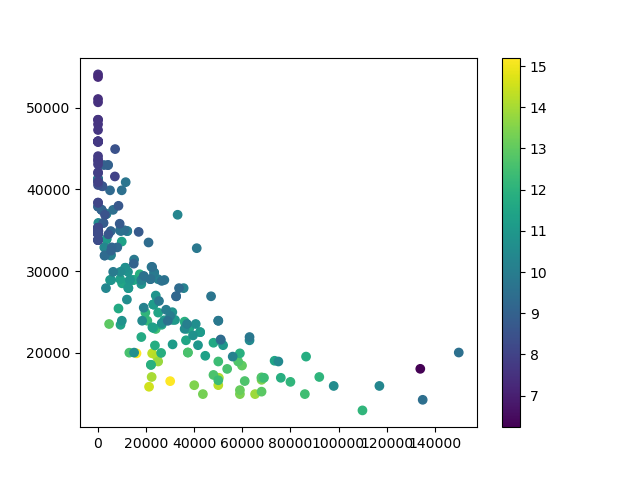

In [103]:
fig, ax = plt.subplots()
plt.scatter(df.mileage, df.price, c=fig_of_merit, cmap='viridis')
plt.colorbar()